# Examples 4.4-5

From Parameter Estimation and Inverse Problems, 3rd edition, 2018    
by R. Aster, B. Borchers, C. Thurber

## Implemented in Python by:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

---

In [1]:
%reset -f

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as nla
from scipy.io import loadmat

from peiplib import lcurve
from peiplib.linalg import gsvd, tikhsolve, roughmat
from peiplib.plot import get_cbar_axes

In [2]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

---
## Problem setup

In [3]:
KM2M = 1.0e+3
M2KM = 1.0e-3

# Load test dataset
vsp = loadmat('./data/vsp.mat')

# Number of model parameters (set `k` to an integer >=1 to explore
# the `n_model >= n_data` case in this example).
k = 1
borehole = 1 * KM2M
n_data = 50

dy = borehole / n_data
dd = dy / k
n_model = k * n_data

# ----------
# Generate the true smooth model
depth = np.arange(0, borehole + 1, 1)
vel = (3.0 + np.sqrt(depth * M2KM)) * KM2M
strue = 1.0 / vel

# ----------
# Create the noisy observed data
# `dobs` is a vector containing the depths of the different observations.
# `dd` is difference in depth between successive observations.
# `t` contains the noisy observations.
noise = 2.0e-4
dobs = vsp['dobs']
t = vsp['t']

# ----------
# System matrix G
G = np.zeros((n_data, n_model), dtype=np.float64)
for i_data in range(n_data):
    i_endcol = (i_data + 1) * k
    G[i_data, :i_endcol] = dd

---
## Example 4.4

We first plot the **true model**:

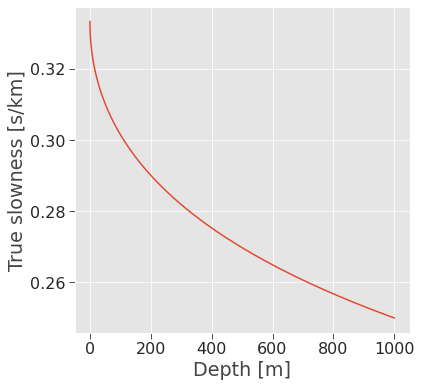

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(depth, strue * KM2M)
ax.set(xlabel='Depth [m]', ylabel='True slowness [s/km]');

To compute the least-squares solution of $\textbf{G}$:

In [5]:
if n_data == n_model:
    m_ls = nla.solve(G, t)
else:
    m_ls = nla.lstsq(G, t)[0]

Cell below plots the least-square solutions and confidence intervals:

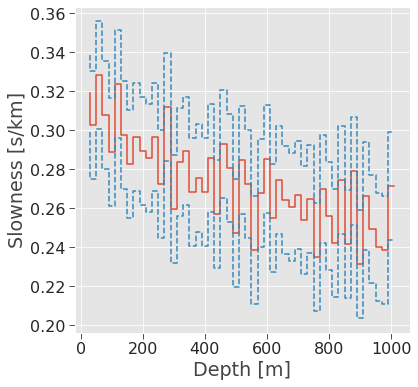

In [6]:
# Plot the least-squares solution and confidence intervals
covmat_ls = (noise**2) * nla.inv(G.T @ G)
conf95 = 1.96 * np.sqrt(np.diag(covmat_ls))
conf95 = conf95.reshape(n_model, 1)

dz = dobs[1] - dobs[0]
dobs2 = dobs + (dz / 2)

fig, ax = plt.subplots(1, 1)
ax.plot(dobs2, m_ls*KM2M, '-',drawstyle='steps')
dum = ax.plot(dobs2, (m_ls + conf95)* KM2M, '--', drawstyle='steps')
color = plt.get(dum[0], 'color')
ax.plot(dobs2, (m_ls - conf95) * KM2M, '--', color=color, drawstyle='steps')
ax.set(xlabel='Depth [m]', ylabel='Slowness [s/km]');

### Apply first-order Tikhonov regularisation

Code cell below shows how we can get the 1st-order Tikhonov regularization L-curve for this problem:

1st-order regularization parameter is: 1.22e+02



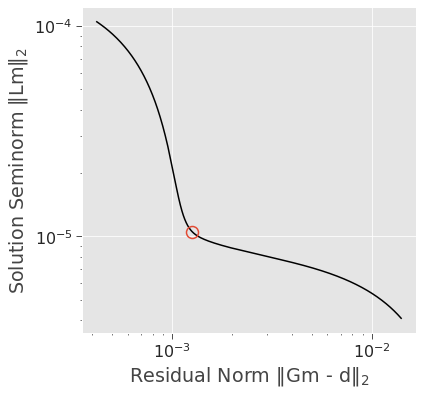

In [7]:
np.seterr(divide='ignore')

L1 = roughmat(n_model, 1, full=True)
U1, V1, X1, LAM1, MU1 = gsvd(G, L1)

# Apply the L-curve criteria to the 1st-order regularization problem
rhos1, etas1, alphas1 = lcurve.tikh_gsvd(U1, X1, LAM1, MU1, t, G, L1, 1200)

# Plot 1st-order L-curve and find its corner
rho_c1, eta_c1, alpha_c1 = lcurve.corner_maxcurv(rhos1, etas1, alphas1)

fig, ax = plt.subplots(1, 1)
ax.loglog(rhos1, etas1, 'k')
ax.plot(rho_c1, eta_c1, 'o', mfc='None', ms=12)
ax.set(
    xlabel=r'Residual Norm $\Vert$Gm - d$\Vert_2$',
    ylabel=r'Solution Seminorm $\Vert$Lm$\Vert_2$')

print(f'1st-order regularization parameter is: {alpha_c1:.2e}\n')

and the corresponding **1st-order** regularised solution is:

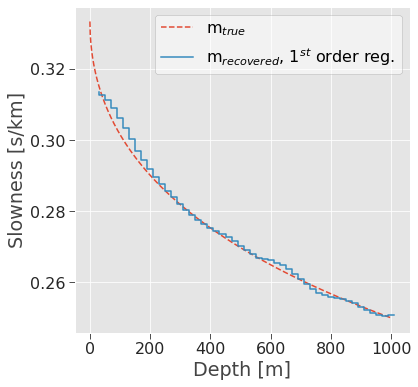

In [8]:
# Get the desired model.
m1 = tikhsolve(G, L1, alpha_c1, t)

# Plot the first-order recovered model and the true model.
fig, ax = plt.subplots(1, 1)
ax.plot(depth, strue * KM2M, '--', label=r'm$_{true}$')
ax.plot(dobs2, m1 * KM2M, '-', drawstyle='steps',
        label=r'm$_{recovered}$, 1$^{st}$ order reg.')
ax.set(xlabel='Depth [m]', ylabel='Slowness [s/km]')
ax.legend();

### Apply second-order Tikhonov regularisation

1st-order regularization parameter is: 2.10e+03



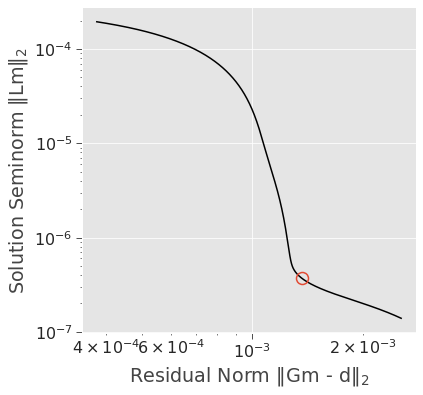

In [9]:
L2 = roughmat(n_model, 2, full=True)
U2, V2, X2, LAM2, MU2 = gsvd(G, L2)

# Apply the L-curve criteria to the 2nd-order regularization problem
rhos2, etas2, alphas2 = lcurve.tikh_gsvd(U2, X2, LAM2, MU2, t, G, L2, 1200)

# Plot 1st-order L-curve and find its corner
rho_c2, eta_c2, alpha_c2 = lcurve.corner_maxcurv(rhos2, etas2, alphas2)

fig, ax = plt.subplots(1, 1)
ax.loglog(rhos2, etas2, 'k')
ax.plot(rho_c2, eta_c2, 'o', mfc='None', ms=12)
ax.set(
    xlabel=r'Residual Norm $\Vert$Gm - d$\Vert_2$',
    ylabel=r'Solution Seminorm $\Vert$Lm$\Vert_2$')

print(f'1st-order regularization parameter is: {alpha_c2:.2e}\n')

and the corresponding **2nd-order** regularised solution is:

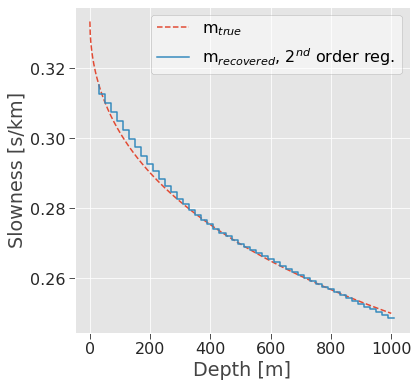

In [10]:
# Get the desired model.
m2 = tikhsolve(G, L2, alpha_c2, t)

# Plot the first-order recovered model and the true model.
fig, ax = plt.subplots(1, 1)
ax.plot(depth, strue * KM2M, '--', label=r'm$_{true}$')
ax.plot(dobs2, m2 * KM2M, '-', drawstyle='steps',
        label=r'm$_{recovered}$, 2$^{nd}$ order reg.')
ax.set(xlabel='Depth [m]', ylabel='Slowness [s/km]')
ax.legend();

### Filter factors

Code cell below shows how we can calculate and display filter factors corresponding to these 1st- and 2nd-order solutions.

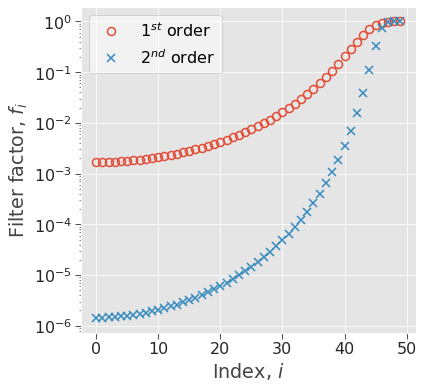

In [11]:
np.seterr(invalid='ignore')

gamma1 = np.sqrt(np.diag(LAM1.T @ LAM1)) / np.sqrt(np.diag(MU1.T @ MU1))
f1 = gamma1**2 / (gamma1**2 + alpha_c1**2)
f1[np.isnan(f1)] = 1.0

gamma2 = np.sqrt(np.diag(LAM2.T @ LAM2)) / np.sqrt(np.diag(MU2.T @ MU2))
f2 = gamma2**2 / (gamma2**2 + alpha_c2**2)
f2[np.isnan(f2)] = 1.0

fig, ax = plt.subplots(1, 1)
ax.semilogy(f1, 'o', label=r'1$^{st}$ order', mfc='none')
ax.semilogy(f2, 'x', label=r'2$^{nd}$ order')
ax.set(xlabel=r'Index, $i$', ylabel=r'Filter factor, $f_i$')
ax.legend();

---
## Example 4.5

In this example, to examine the resolution of the Tikhonov regularized inversions of Example 4.4, we perform a spike test.

### Compute the resolution matrix for **1st order** regularisation

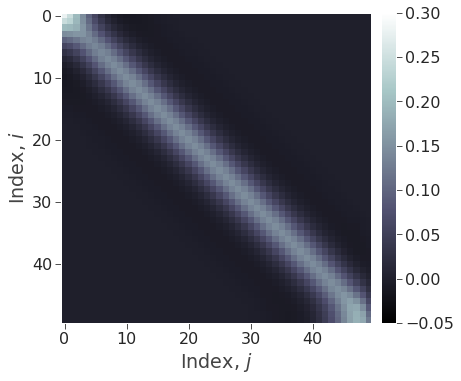

In [12]:
F1 = np.diag(f1)
R1 = nla.inv(X1.T) @ F1 @ X1.T

fig, ax = plt.subplots(1, 1)
cimg = ax.imshow(R1, vmin=-0.05, vmax=0.30, cmap='bone')
cax = get_cbar_axes(ax)
cbar = plt.colorbar(cimg, cax=cax)
ax.set(xlabel=r'Index, $j$', ylabel=r'Index, $i$')
ax.grid(False)

### Compute the resolution matrix for **2nd** order regularisation

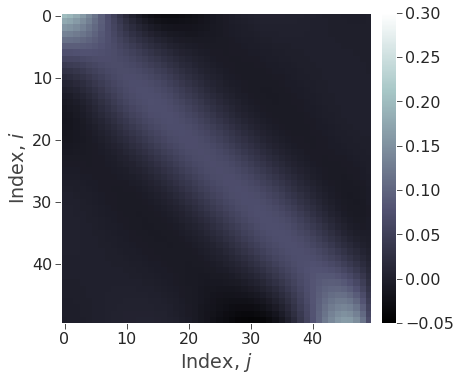

In [13]:
F2 = np.diag(f2)
R2 = nla.inv(X2.T) @ F2 @ X2.T

fig, ax = plt.subplots(1, 1)
cimg = ax.imshow(R2, vmin=-0.05, vmax=0.30, cmap='bone')
cax = get_cbar_axes(ax)
cbar = plt.colorbar(cimg, cax=cax)
ax.set(xlabel=r'Index, $j$', ylabel=r'Index, $i$')
ax.grid(False)

### Spike-model resolution test

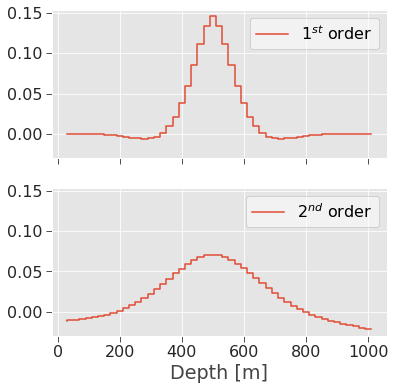

In [14]:
spike = np.zeros((n_model, 1), dtype=np.float64)
spike[int(round(n_model / 2.0) - 1)] = 1.0

# The models that would be recovered.
r1 = R1 @ spike
r2 = R2 @ spike

# Plot the recovered spike models.
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True)
ax0.plot(dobs2, r1, drawstyle='steps', label=r'1$^{st}$ order')
ax1.plot(dobs2, r2, drawstyle='steps', label=r'2$^{nd}$ order')
ax1.set_xlabel('Depth [m]')
ax0.legend()
ax1.legend();